In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.pyplot import figure
import moviepy.editor as mp
import ffmpeg
import ffmpy
from ffmpy import FFmpeg

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "figure.figsize": [12,6],
    "figure.dpi": 100
})

In [17]:
DSAFull = pd.read_csv("Chua-Circuit-Waveform-CSV/RigolDS-Point.csv")

# A shortened version of the full scope capture, feel free to shorten this even further (skipfooter=950000 is manageable)

DSAShort = pd.read_csv("Chua-Circuit-Waveform-CSV/RigolDS-Point.csv", skipfooter=999500)

# Uncomment the below code to plot the full waveform (contains 1 million points)

    #fig = plt.figure(dpi=1800)
    #fig, ax = plt.subplots()
    #ax.plot(DSAFull.CH2V, DSAFull.CH1V, color = '#e6e6e6', marker = ',')
    #ax.set_facecolor('#171717')

# DSAM is a shortened version of DSAShort which will be used for the animation below. Here, 20 indicates that every 20th datapoint is 
# selected for DSAM. We create a new column in the dataframe that determines the time measurement of each (x, y). 1.6*10^-4 is the
# time increment for each recorded point.

DSAM = DSAShort.iloc[::1, :]
DSAM['t'] = DSAM.index * 1.6 * 10 ** -4

In [18]:
# Determine from dataframe the range and domain of the plot, then determine the margin

ymax = DSAM['CH1V'].max()
ymin = DSAM['CH1V'].min()
xmax = DSAM['CH2V'].max()
xmin = DSAM['CH2V'].min()

ydev = 0.1 * (abs(ymax) + abs(ymin))
xdev = 0.1 * (abs(xmax) + abs(xmin))

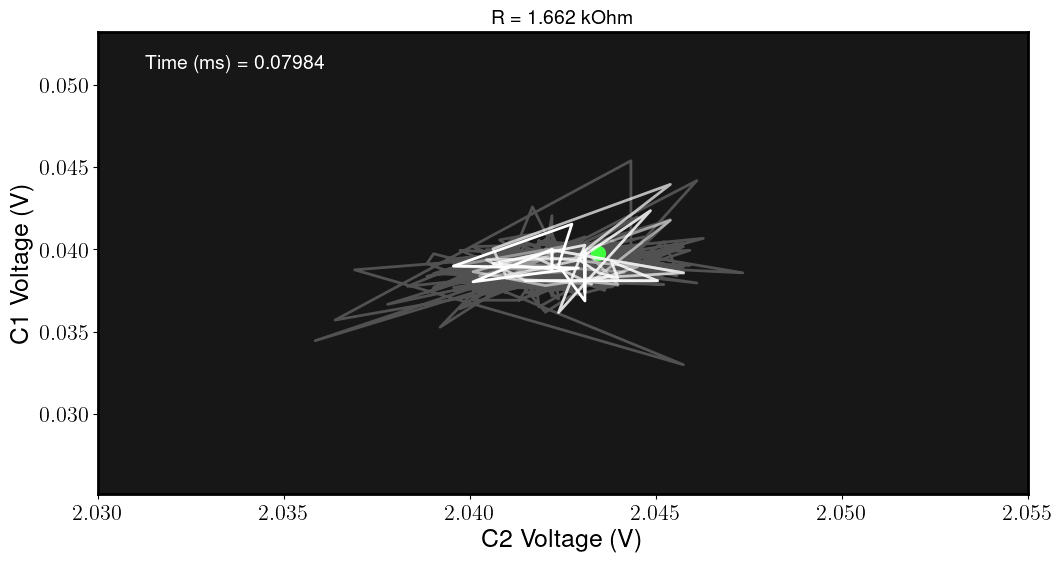

In [19]:
# WARNING: Using 20 points from a sample of 300000, as was done with the double scroll, will draw then store 15000 plots to memory (~42 GB)

# Define all of the important plot elements below. The tracerline variations are my inelegant solution to creating a fading line behind
# the path of the voltage relationship. 

# NOTE: The tracerline implies that this isn't a discrete collection of points -- it is. The use of lines instead of points was stylistic 
# and helps to make sense of the voltage relationship path as the plot gets overwritten with overlapping paths.

fig, ax = plt.subplots()
tracerpoint, = ax.plot(DSAM.CH2V, DSAM.CH1V, color='#00FF00', marker=".", ms=20)
tracerline, = ax.plot(DSAM.CH2V, DSAM.CH1V, color='white', alpha=1)
tracerlinewounded, = ax.plot(DSAM.CH2V, DSAM.CH1V, color='white', alpha=0.85)
tracerlinedying, = ax.plot(DSAM.CH2V, DSAM.CH1V, color='white', alpha=0.70)
tracerlinelifesupport, = ax.plot(DSAM.CH2V, DSAM.CH1V, color='white', alpha=0.55)
tracerlinedead, = ax.plot(DSAM.CH2V, DSAM.CH1V, color='white', alpha=0.40)
tracerlineburied, = ax.plot(DSAM.CH2V, DSAM.CH1V, color='white', alpha=0.25)
ax.set_facecolor('#171717')
ax.set_xlabel('C2 Voltage (V)')
ax.set_ylabel('C1 Voltage (V)')
ax.set_title('R = 1.662 kOhm')
title = ax.text(0.05,0.95, "", bbox={'facecolor':'#171717', 'alpha':1, 'pad':5, 'color':'#171717'},
                transform=ax.transAxes, ha='left', va='top', color='white')
tracerpoint.axes.axis([2.03, 2.055, ymin - ydev, ymax + ydev])

# Set tracer tail length

ttl = 10

# A function to update each of the plot elements. Again, this is extremely inelegant. the max() function is required, else it will create
# strange behavior with the transparency of the line. round() is required, else the reported time on the graph will contain floating point
# precision errors.

def update(num, x, y, tracerpoint):
    tracerpoint.set_data(x.iloc[num, 1], y.iloc[num, 0])
    tracerlineburied.set_data(x.iloc[:max(0, num-(5*ttl-2)), 1], y.iloc[:max(0, num-(5*ttl-2)), 0])
    tracerlinedead.set_data(x.iloc[max(0, num-5*ttl):max(0, num-(4*ttl-2)), 1], y.iloc[max(0, num-(5*ttl)):max(0, num-(4*ttl-2)), 0])
    tracerlinelifesupport.set_data(x.iloc[max(0, num-(4*ttl)):max(0, num-(3*ttl-2)), 1], y.iloc[max(0, num-(4*ttl)):max(0, num-(3*ttl-2)), 0])
    tracerlinedying.set_data(x.iloc[max(0, num-(3*ttl)):max(0, num-(2*ttl-2)), 1], y.iloc[max(0, num-(3*ttl)):max(0, num-(2*ttl-2)), 0])
    tracerlinewounded.set_data(x.iloc[max(0, num-(2*ttl)):max(0, num-(ttl-2)), 1], y.iloc[max(0, num-(2*ttl)):max(0, num-(ttl-2)), 0])
    tracerline.set_data(x.iloc[max(0, num-ttl):num, 1], y.iloc[max(0, num-ttl):num, 0])
    title.set_text(u"Time (ms) = {}".format(round(x.iat[num, 5], 5)))
        
    return tracerpoint,

ani = animation.FuncAnimation(fig, update, len(DSAM.index), fargs=[DSAM, DSAM, tracerpoint],
                              interval=10, blit=True)
ani.save('out.gif', writer="ffmpeg")

In [20]:
# Moviepy used to take in the output gif from the matplot animation and return an .mp4

clip = mp.VideoFileClip("out.gif")
clip.write_videofile("out.mp4")

Moviepy - Building video out.mp4.
Moviepy - Writing video out.mp4



Moviepy - Done !
Moviepy - video ready out.mp4


In [21]:
# Using moviepy to modify the fps of the aforementioned .mp4. The output of the animation is 10fps, despite my best efforts to modify "interval"
# Currently this is set up to turn a 10fps .mp4 into a 144fps .mp4

from moviepy.editor import VideoFileClip
import moviepy.video.fx.all as vfx

in_loc = 'out.mp4'
out_loc = 'Animations/1.662k-CC-Point.mp4'

# Import video
clip = VideoFileClip(in_loc)
print("fps: {}".format(clip.fps))

# Change FPS
clip = clip.set_fps(clip.fps * 14.4)

# Apply FPS Change
final = clip.fx(vfx.speedx, 14.4)
print("fps: {}".format(final.fps))

# Save video
final.write_videofile(out_loc)

fps: 10.0
fps: 144.0
Moviepy - Building video Animations/1.662k-CC-Point.mp4.
Moviepy - Writing video Animations/1.662k-CC-Point.mp4



Moviepy - Done !
Moviepy - video ready Animations/1.662k-CC-Point.mp4
